# The H2 production problem 

The LCOH is the ratio of NPV of the total costs over the actualized total production over the project lifetime.

$$ LCOH = \frac{\sum_{t=0}^{N} \frac{CAPEX_{t} + OPEX_{t}}{(1+r)^t}}{\sum_{t=0}^{N} \frac{H2_{produced}}{(1+r)^t}} $$

Given project parameters and hourly grid electricity price and PV generation power we look to minimize LCOH

#### Approach

Simple model where we derive levelized cost of hydrogen (LCOH) from annualized life cycle costs (LCC) - investment and fixed operational costs and electricity cost computed from available data.

$$LCOH = \frac{LCC_{a}}{Prod_{H2,a}} = \frac{c_{cap,a} + c_{fixed} + c_{elec}(q_{H2})}{q_{H2}}$$ 
    
    
**Optimization** :
Given cost parameters input (incl. electricity grid prices), we solve for the optimal H2 production schedule that minimizes LCOH

**Breakdown of life cycle costs**

* *Investment costs (CAPEX)*: Initial investment is simply annualized over the project lifetime using the CRF formula

  $$ c_{cap, a} = \frac{r \cdot (1+r)^n}{(1+r)^n - 1} * c_{cap} $$
    

* *Fixed costs (OPEX)*: Constant annual amount for maintenance costs $c_{fixed}$

* *Variable costs (OPEX)*: Annual electricity cost (no water cost) - result of production planning optimization
  
  $$ c_{elec} = \sum_{t=0}^{8760} \sum_{i=1}^{5} x_{i,t} \cdot p_{i,t} + x_{grid, t} \cdot p_{grid,t} $$
      
  where
  - $x_i$ is power from PV unit $i$
  - The sum of power  each sources yields H2 production at given time
    
  $$ q_{H2, t} = \rho_{Effiency factor} * \sum_{i=1}^{5} x_{i, t} \cdot p_{i,t} + x_{grid, t} \cdot p_{grid, t} $$
      

### 1. Input data

In [ ]:
pip install datetimerange pulp plotly notebook ipywidgets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary packages

import csv 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetimerange
import datetime
from datetimerange import DateTimeRange
from datetime import datetime, timedelta

#### Electricity market data

In [ ]:
# Load price data
grid_data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/data/elec_data.xlsx', sheet_name='Grid')

In [ ]:
# Add source variable column
grid_data['Source'] = 'Grid'
# Reorder columns
grid_data = grid_data[['Date', 'Source', 'MWh', '€/MWh']]

# Check format
grid_data

,Date,Source,MWh,€/MWh
0,2018-01-01 00:00:00,Grid,23012.5,6.74
1,2018-01-01 01:00:00,Grid,24971.6,4.74
2,2018-01-01 02:00:00,Grid,25130.8,3.66
3,2018-01-01 03:00:00,Grid,22324.4,1.26
4,2018-01-01 04:00:00,Grid,22617.6,-20.10
...,...,...,...,...
8755,2018-12-31 19:00:00,Grid,8536.6,58.28
8756,2018-12-31 20:00:00,Grid,7235.8,50.01
8757,2018-12-31 21:00:00,Grid,7238.4,45.50
8758,2018-12-31 22:00:00,Grid,5999.4,49.80


#### PV units data

In [ ]:
# PV units assumptions - TEMP - 
unit_assumptions = {
    'Unit 1': {'Capacity' : 8, 'LCOE': 3.5},      # Capacity in MW, LCOE in €
    'Unit 2': {'Capacity' : 12, 'LCOE': 1.25},
    'Unit 3': {'Capacity' : 7, 'LCOE': 30.5},
    'Unit 4': {'Capacity' : 3, 'LCOE': 13.5},
    'Unit 5': {'Capacity' : 5, 'LCOE': 0.5}
    }

PV_assumptions = pd.DataFrame(unit_assumptions)
PV_assumptions

,Unit 1,Unit 2,Unit 3,Unit 4,Unit 5
Capacity,8.0,12.00,7.0,3.0,5.0
LCOE,3.5,1.25,30.5,13.5,0.5


In [ ]:
# Load production profile
pv_raw = pd.read_excel('/content/drive/My Drive/Colab Notebooks/data/elec_data.xlsx', sheet_name='PV')

In [ ]:
# Reshape to long format
pv_data = pv_raw.melt(id_vars=['Date'])
# Rename variables
pv_data.rename(columns= {'variable':'Source', 'value':'MWh'}, inplace=True)
# Add price variable column
pv_data['€/MWh'] = pv_data.apply(lambda row: unit_assumptions[row.Source]['LCOE'], axis= 1)

# Check format
pv_data

,Date,Source,MWh,€/MWh
0,2018-01-01 00:00:00,Unit 1,0.0,3.5
1,2018-01-01 01:00:00,Unit 1,0.0,3.5
2,2018-01-01 02:00:00,Unit 1,0.0,3.5
3,2018-01-01 03:00:00,Unit 1,0.0,3.5
4,2018-01-01 04:00:00,Unit 1,0.0,3.5
...,...,...,...,...
43795,2018-12-31 19:00:00,Unit 5,0.0,0.5
43796,2018-12-31 20:00:00,Unit 5,0.0,0.5
43797,2018-12-31 21:00:00,Unit 5,0.0,0.5
43798,2018-12-31 22:00:00,Unit 5,0.0,0.5


#### Full dataset

In [ ]:
# Merge both sources of data into single dataframe
elec_price = pd.concat([grid_data, pv_data], axis= 0)

# set hierarchical index by time and source
elec_price.set_index(['Date', 'Source'], inplace= True)
elec_price.sort_index(inplace= True)

# format check
elec_price

MWh  €/MWh
Date                Source                
2018-01-01 00:00:00 Grid    23012.5   6.74
                    Unit 1      0.0   3.50
                    Unit 2      0.0   1.25
                    Unit 3      0.0  30.50
                    Unit 4      0.0  13.50
...                             ...    ...
2018-12-31 23:00:00 Unit 1      0.0   3.50
                    Unit 2      0.0   1.25
                    Unit 3      0.0  30.50
                    Unit 4      0.0  13.50
                    Unit 5      0.0   0.50

[52560 rows x 2 columns]

In [ ]:
# Summary statistics of grid data
#elec_price.describe()

In [ ]:
# plot electricity price - DEPRECATED
#elec_price = elec_data['Grid'].set_index('Date')

#ax_Eprice = elec_price['€/MWh'].plot(marker='.', alpha=0.4, figsize=(15, 7))
#ax_Eprice.set_title('Price of available electricity sources (2018)')
#ax_Eprice.set_ylabel('Spot Price (€)')
#ax_Eprice.axhline(linewidth=0.5, color='r')

### 2. Model

#### Problem formulation

\begin{equation}
\begin{aligned}
& \min_{x_{i,t}} 
& & \frac{c_{cap,a} + c_{fixed} + \sum_{t=0}^{8760} \sum_{i=1}^{6} x_{i,t} \cdot p_{i,t}}{\tau \cdot \sum_{t=0}^{8760} \sum_{i=1}^{6} x_{i,t}} \equiv \text{LCOH} \\
& s.t 
& & \sum_{i=1}^{6} x_{i,t} \le Q(H2)_{max} 
& & & \forall \quad t \\
&
& & 0 \le x_{i,t} \le W(avail)_{i, t} 
& & & \forall \quad t, i \\
\end{aligned}
\end{equation}

In order to solve the problem by LP we need to further assume that the denominator - H2 production - of the objective function is strictly posive.

#### Parameters

In [ ]:
# General assumptions
n = 20     # project lifetime
r = 0.05   # discount rate

# Plant assumptions
electrolyzer_cap = 300      # electrolyzer capacity in MW
eff_factor = 100            # Energy efficiency in %
cap_cost = 34.9 * 10**6     # investment cost in €
fixed_cost = 500 * 10**3    # annual fixed maintenance costs in €

In [ ]:
# Annualized investment costs
CRF = r*(1+r)**n / ((1+r)**n - 1)
cap_cost_a = CRF * cap_cost

cap_cost_a

2800466.2929551257

#### Optimization

In order to compute the optimization as an LP problem, we reformulate using the Charnes-Cooper transformation.

An additional constraint for a solution to exist will is that production be positive.

In [ ]:
from pulp import *

In [ ]:
# Denominator substitution variable - Total purchase of electricity
y0 = LpVariable('y0', lowBound= 0, cat= 'Continuous')                                            # must be positive 

# Variables dictorionnary - Scaled purchase of electricity
y = LpVariable.dicts("y",                                                                        # variable prefix   
                    ((time, source) for time, source in elec_price.index),                       # one variable per source and time
                    lowBound= 0,                                                                 # can't have negative input
                    cat= 'Continuous')

# Initialize optimization problem - object contains problem data
model = LpProblem("LCOE minizing production schedule", LpMinimize)

# Objective function - minimize LCC
model += y0 * (cap_cost_a + fixed_cost) + lpSum([y[time, source] * elec_price.loc[(time, source), '€/MWh'] for time, source in elec_price.index])

# Define LCOE denominator in an equality constraint
model += lpSum([y[time, source] for time, source in elec_price.index]) == 1              

# Production in any hour cannot exceed eletrolyzer capacity
date_time = grid_data['Date']                                                                     # list of all hours in the year
sources = elec_price.index.get_level_values(1).drop_duplicates()                                  # list of all 6 power sources
for datetime in date_time:
    model += lpSum([y[datetime, source] for source in sources]) - y0 * electrolyzer_cap <= 0      # add constraint for each hour to the model

# input from each source cannot exceed current available production
for time, source in elec_price.index:
    model += y[time, source] - y0 * elec_price.loc[(time, source), 'MWh'] <= 0

# The problem data is written to an .lp file
model.writeLP("Production H2.lp")

In [ ]:
# The problem is solved using PuLP's choice of Solver
model.solve()

1

#### Output

In [ ]:
value(model.objective)

25.488280545846223

In [ ]:
y0.varValue

3.7280759e-06

In [ ]:
# Export optimization results and convert them back to original model

# Convert objective function
lcoh = value(model.objective)

# Store decision variables values in dict
y_opt = pd.Series({v.name: v.varValue for v in model.variables()})
y_opt.pop('y0')       #keep only actual y_i,t values
model_output = y_opt.div(y0.varValue)

# Create dataframe
df = pd.DataFrame(data= {'Date': elec_price.index.get_level_values(0), 'Source': elec_price.index.get_level_values(1), 'Value': model_output})
df.reset_index(inplace= True)

# Matching check - quite long
#check = sum([str(df.loc[i]['Date']).replace(" ", "_").replace("-", "_") in df.loc[i]['index'] and df.loc[i]['Source'].replace(" ", "_") in df.loc[i]['index'] for i in range(len(df))])
#if check == 52560:
#  print("Date-time and sources match")
#else:
#  print("Couldn't proceed - index and var_names don't match")

# Format dataframe for result presentation
df = df.drop('index', axis= 1)
elec_use = df.pivot(index='Date', columns='Source', values='Value')
elec_use.head(20)

Source,Grid,Unit 1,Unit 2,Unit 3,Unit 4,Unit 5
Date,,,,,,
2018-01-01 00:00:00,300.000008,0.000000,0.000000,0.0,0.000000,0.000000
2018-01-01 01:00:00,300.000008,0.000000,0.000000,0.0,0.000000,0.000000
2018-01-01 02:00:00,300.000008,0.000000,0.000000,0.0,0.000000,0.000000
2018-01-01 03:00:00,300.000008,0.000000,0.000000,0.0,0.000000,0.000000
2018-01-01 04:00:00,300.000008,0.000000,0.000000,0.0,0.000000,0.000000
2018-01-01 05:00:00,300.000008,0.000000,0.000000,0.0,0.000000,0.000000
2018-01-01 06:00:00,300.000008,0.000000,0.000000,0.0,0.000000,0.000000
2018-01-01 07:00:00,300.000008,0.000000,0.000000,0.0,0.000000,0.000000
2018-01-01 08:00:00,300.000008,0.000000,0.000000,0.0,0.000000,0.000000


### 3. Results

In [ ]:
# Import ploting packages
import plotly.offline as py

py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import plotly.io as pio
pio.renderers.default = "colab"

#### Baseline

In [ ]:
# Basic results
print(f"Levelized cost of hydrogen: {round(lcoh, 2)} €/MWh")
print(f"Total production (annual): {round(1/y0.varValue)} MWh")  

Levelized cost of hydrogen: 25.49 €/MWh
Total production (annual): 268235 MWh


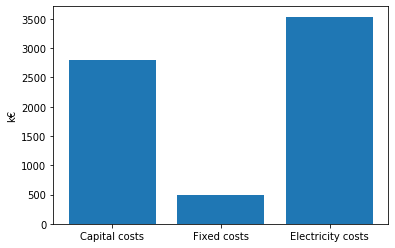

In [ ]:
# Total costs
elec_cost = np.dot(np.array(df.Value), np.array(elec_price.loc[:,'€/MWh']))

# Store cost values in a dict
costs = {
    "Capital costs": round(cap_cost_a) / 10**3,
    "Fixed costs": fixed_cost / 10**3,
    "Electricity costs": round(elec_cost) / 10**3
}

# Plot results
plt.bar(range(len(costs)), list(costs.values()) ,align='center')
plt.xticks(range(len(costs)), list(costs.keys()))
plt.ylabel('k€')
plt.show()

In [ ]:
# Pie chart layout

pie = go.Pie(labels=list(costs.keys()), values=list(costs.values()))
layout = go.Layout(title='Costs split (k€)')
fig = go.Figure(data=[pie], layout=layout)
py.offline.iplot(fig)

#### Production schedule

In [ ]:
from plotly.subplots import make_subplots

# Create subploots
fig2 = make_subplots(rows= 6, cols=2,
                    subplot_titles =('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec') 
                    )

# Add time series by month

for month in range(1, 13):
  i = (month+1) // 2
  j = (month+1) % 2 +1
  for source in sources:
    fig2.add_trace(
        go.Bar(name= source, x=elec_use[f'2018-{month}'].index, y=elec_use[f'2018-{month}'][source]),
        row=i, col=j
    )

# Plot format and display
fig2.update_layout(title_text='H2 production schedule', barmode='stack', showlegend=False, height=1000)
fig2.update_yaxes(title_text="MWh")
fig2.show()

In [ ]:
# Electricity usage by source
fig3 = go.Figure(
          data= [go.Box(y= elec_use[source], name= source) for source in sources]      
)

fig3.update_layout(title='Electricity usage by source')
fig3.update_yaxes(title_text="MWh")

fig3.show()

#### Additional checks

In [ ]:
# How does spot electricity price affect electricity usage mix ?

fig4 = make_subplots(rows= 2, cols= 3,
                     subplot_titles=sources)

# add grid plot
fig4.add_trace(go.Scattergl(x= elec_use['Grid'], y= grid_data['€/MWh'], name='Grid', mode='markers'), row=1, col=1)

# add PV usage plots
fig4.add_trace(go.Scattergl(x= elec_use['Unit 1'], y= grid_data['€/MWh'], name='Unit 1', legendgroup='unit1', mode='markers'), row=1, col=2)
fig4.add_trace(go.Scattergl(x= elec_use['Unit 2'], y= grid_data['€/MWh'], name='Unit 2', legendgroup='unit2', mode='markers'), row=1, col=3)
fig4.add_trace(go.Scattergl(x= elec_use['Unit 3'], y= grid_data['€/MWh'], name='Unit 3', legendgroup='unit3', mode='markers'), row=2, col=1)
fig4.add_trace(go.Scattergl(x= elec_use['Unit 4'], y= grid_data['€/MWh'], name='Unit 4', legendgroup='unit4', mode='markers'), row=2, col=2)
fig4.add_trace(go.Scattergl(x= elec_use['Unit 5'], y= grid_data['€/MWh'], name='Unit 5', legendgroup='unit5', mode='markers'), row=2, col=3)

# add PV LCOE lines
fig4.add_trace(go.Scattergl(x= elec_use['Unit 1'], y= [PV_assumptions['Unit 1']['LCOE'] for x in elec_use['Unit 1']], name='Unit 1 - LCOE', legendgroup='unit1', mode='lines'), row=1, col=2)
fig4.add_trace(go.Scattergl(x= elec_use['Unit 2'], y= [PV_assumptions['Unit 2']['LCOE'] for x in elec_use['Unit 2']], name='Unit 2 - LCOE', legendgroup='unit2', mode='lines'), row=1, col=3)
fig4.add_trace(go.Scattergl(x= elec_use['Unit 3'], y= [PV_assumptions['Unit 3']['LCOE'] for x in elec_use['Unit 3']], name='Unit 3 - LCOE', legendgroup='unit3', mode='lines'), row=2, col=1)
fig4.add_trace(go.Scattergl(x= elec_use['Unit 4'], y= [PV_assumptions['Unit 4']['LCOE'] for x in elec_use['Unit 4']], name='Unit 4 - LCOE', legendgroup='unit4', mode='lines'), row=2, col=2)
fig4.add_trace(go.Scattergl(x= elec_use['Unit 5'], y= [PV_assumptions['Unit 5']['LCOE'] for x in elec_use['Unit 5']], name='Unit 5 - LCOE', legendgroup='unit5', mode='lines'), row=2, col=3)

# Layout and display
fig4.update_layout(height=800)
fig4.update_xaxes(title_text='Electric use (MWh)')
fig4.update_yaxes(title_text='Spot Price (€/MWh)')
fig4.show()

In [ ]:
# Alt view - all in single frame (less clear)
#fig5 = go.Figure(
#    data=[go.Scattergl(x=grid_data['€/MWh'], y= elec_use[source], name= source, mode='markers') for source in sources])


#fig5.show()

In [ ]:
# Plot daily H2 production vs. electricity price 

# Aggregate lower frequency (daily) data
total_prod = df.set_index(['Date', 'Source']).groupby(level=0).sum()
total_prod_daily = total_prod.resample('D').sum().round()
grid_price = grid_data.set_index('Date')['€/MWh'].resample('D').mean()

# Create figure object and subplots layout
fig6 = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.2)

# Add daily production series
fig6.add_trace(go.Scattergl(
    x = total_prod_daily.index,
    y = total_prod_daily['Value'],
    mode = 'lines',
    name = 'H2 production'),
    row=1, col=1)

# Add price time series
fig6.add_trace(go.Scattergl(
    x = total_prod_daily.index,
    y = grid_price,
    mode = 'lines',
    name = 'Spot Price'),
    row=2, col=1)

# Layout
fig6.update_layout(height=600)
fig6.update_yaxes(title_text='MWh', row=1, col=1)
fig6.update_yaxes(title_text='€/MWh', row=2, col=1)
fig6.show()

# Conclusion

To do:
*   Wrap optimizer in function
*   Assesment and tuning of baseline assumptions

Moving forward:
*   Run some simulations to assess LCOE sensitivity to parameters ?
*   Layout excel pipeline


